# Intro: Component Separation

## Principal Component Analysis (PCA)

##### PCA Example: 3-dimensional data -> 2- dimensional data

![alt text](http://www.nlpca.org/fig_pca_principal_component_analysis.png "Galactic Microwave Foreground SED")
###### Image from Ph.D. Thesis of Matthias Scholz,  Potsdam U. Germany:
`http://phdthesis-bioinformatics-maxplanckinstitute-molecularplantphys.matthias-scholz.de/`

## Independent Component Analysis (ICA)
  * Similar to PCA
  * Transforms data 
  * Maximizes variance between comonents!
  * Assumes linear combination
  * Cannot separate gaussian components!

> "ICA is a quite powerful technique and is able (in principle) to separate independent sources linearly mixed in several sensors."  

-Arnaud Delorme, Centre de Recherche Cerveau & Cognition

### "Ground-truth" Signals:
![alt text](https://sccn.ucsd.edu/~arno/ica/ab.jpg)

### Observed (mixed) Signal:
![alt text](https://sccn.ucsd.edu/~arno/ica/m1m2.jpg)

### Result of ICA Separation (assuming 2 sources!):
![alt text](https://sccn.ucsd.edu/~arno/ica/fastica.jpg)

###### Example images borrowed from Arnaud Delorme (Centre de Recherche Cerveau & Cognition) :
http://arnauddelorme.com/ica_for_dummies/


## Intro: Non-negative matrix factorization
  * Similar to ICA
  * Forces positive components
  * More physically interpretable than ICA

# Demonstration: Decomposing Emission Sources in DIRBE Maps
  1. PCA
  2. ICA
  3. NMF

In [2]:
## Setup packages

import os #  call basic shell commands from inside python
import numpy as np # numerical and array calculations
import healpy as hp # all-sky "HEALPix" map format
import pandas as pd # R-like dataframe operations
#import seaborn as sb # pretty data visualizations
#import scipy
%matplotlib inline 
# needed to make plots appear in a Jupyter notebook without crashing

## Demo: Get the data:

Example shell script to get DIRBE maps from CADE@IRAP Data mirror:

```
#!/bin/bash
for i in {1..10}
do
curl -fO http://cade.irap.omp.eu/documents/Ancillary/DIRBE/DIRBE_"${i}"_256.fits
done
exit 0
```

Note that this will get the Zodi-included maps!!! These are necessary, to see of the Zodi can be isolated via blind methods)

##### See CADE Documentation for more info:
`http://cade.irap.omp.eu/dokuwiki/doku.php?id=dirbe`

In [3]:
dirbelist = os.listdir('data/dirbezodi/')
dirbelist

['DIRBE_1_256.fits',
 'DIRBE_2_256.fits',
 'DIRBE_3_256.fits',
 'DIRBE_4_256.fits',
 'DIRBE_5_256.fits',
 'DIRBE_6_256.fits',
 'DIRBE_7_256.fits',
 'DIRBE_8_256.fits',
 'DIRBE_9_256.fits',
 'DIRBE_10_256.fits']

In [4]:
dirbelist_bands = ['1.25','2.2','3.5','4.9','12','25','60','100','140','240'] # Wavelength of bands in microns

dirbeframe = pd.DataFrame() # Initialize a blank pandas dataframe

for i in range(0,len(dirbelist)): #loop through the maps and corresponding wavelenghts
    
    #loads one map per column, with wavelengths as labels
    #you can load as 'NESTED' HEALPix with nest=True, otherwise will be loaded as 'RING' by default
    
    dirbeframe[dirbelist_bands[i]] = hp.read_map('data/dirbezodi/'+dirbelist[i], nest=True)
    
    


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


In [5]:
dirbeframe.head()

,1.25,2.2,3.5,4.9,12,25,60,100,140,240
0,2.888510,5.883951,4.769686,3.683532,34.513210,62.407505,185.299850,473.086578,922.314331,621.317505
1,3.150482,6.144921,4.863726,3.708770,34.148510,63.274231,192.869980,473.605499,897.744507,596.406555
2,3.208883,6.064898,4.660659,3.471967,31.615459,52.134674,129.126633,373.896240,782.620178,543.573914
3,3.627464,6.349942,4.668506,3.389972,30.667419,53.557865,134.750381,357.144958,687.883667,469.977356
4,3.357078,6.002378,4.520679,3.353334,30.404181,51.942192,138.685928,382.639954,748.399353,511.445312


In [ ]:
from matplotlib.colors import SymLogNorm
# Visualize the input maps, for confirmation:
for map in dirbeframe.columns:
    hp.mollview(
        dirbeframe[map], 
        cmap='rainbow',
        unit='MJy/sr',
        title='COBE-DIRBE {} $\mu$m map at NSIDE 256'.format(map),
        norm=SymLogNorm(linthresh=0.01,
                                   linscale=1,vmin=0),
        nest=True)

# Demo: Scaling and Imputing:
  * Scale the data to a range 0 to 1
  * Prevents brighter maps from biasing the covariance
  * Impute bad pixels - replacing with the median (maybe not the best strategy...)
  
Note: Scaling ("whitening") can also be done inside the PCA/ICA/NMF function. Just set `whiten = True`

In [ ]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

def scaleIt(df):
    
    imp = Imputer(missing_values=hp.UNSEEN) # Sets up the imputer object. UNSEEN is the healpix convential badpix value

    imp.fit(df.values) # Find where imputation is needed
    X = imp.transform(df.values) # Actually applies the imputation

    scaler = MinMaxScaler(feature_range=(0, 1)) # Sets up the scaler object

    scaler.fit(X) # Gets the necessary scaling parameters (min and max)
    X = scaler.transform(X)  # Applies the scaling
    
    return X, scaler #scaling parameters returned, so we can easily map back to the input units later 

dirbeframe_scaled, dirbeframe_scaler = scaleIt(dirbeframe)


# Demo: PCA
### Determine the principle components (PCs)

  1. Calculate covariance matrix
  2. Solve for eigenvectors
  3. Eigenvectors give the PCs
  4. Eigenvalues give the "Explanined variance ratio" per PC
  5. Eigenvectors can be mapped back to input data:
  6. Can spatially and spectrally visualize the PCs

To keep the example simple, we use the PCA, ICA and NMF functions built into the package `scikit-learn`.  
For a truly scientific test, we should implement the code ourselves, or carefully evaluate the source code of sklearn.

In [ ]:
from sklearn.decomposition import PCA

def getPCA(X, n_components=2): # In principle, you can have as many components as input vectors
    
    # Principal component analysis
    pca = PCA(n_components=n_components)
    S_pca_ = pca.fit(X).transform(X)
  
    return S_pca_, pca

S_pca_, pca = getPCA(dirbeframe_scaled)

# Demo: PCA
### Visualize the components:
Re-shape each into an all sky map, 
 and show the contributions to each component from the input maps
 
 Code examples referenced:  
 `http://thomas-cokelaer.info/blog/2012/04/481/`

In [ ]:
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt

def visComps(comps, model, labels, title_prefix = "PC_"):
    

    for i in range(0,np.size(comps,axis=1)):
        #plt.subplot(5,4,i+1)
        #plt.figure(figsize=(20,20))
        
        try:
            title = title_prefix+str(i+1)+":  Explained Variance = "+str(
                round(model.explained_variance_ratio_[i]*100,2))+"%"
            
        except(AttributeError):
            title = title_prefix+str(i+1)
        
        hp.mollview(comps[:,i], title= title,
                   cmap = "rainbow", 
                   norm=SymLogNorm(linthresh=0.01,
                                   linscale=1,vmin=0),
                   #norm='hist',
                   nest=True)


        
visComps(S_pca_, pca, dirbeframe.columns)
        

# Demo: PCA
###  Project the PCs along the original components:

In [ ]:


def plotComps(comps, model, scaler,  labels, title_prefix = "PC_"):
    
    for i in range(0,np.size(comps,axis=1)):
        
        
        try:
            title = title_prefix+str(i+1)+":  Explained Variance = "+str(
                round(model.explained_variance_ratio_[i]*100,2))+"%"
            
        except(AttributeError):
            title = title_prefix+str(i+1)
        
        
        
        #x_ = range(0,np.size(model.components_,axis=1))
        x_ = [float(l) for l in labels]
        y_ = model.components_[i]
        y_unscaled = (y_*scaler.data_range_)+scaler.data_min_

        
        #fig, ax = plt.subplots()
            
        # create the general figure
        fig1 = plt.figure()
 
        # and the first axes using subplot populated with data 
        ax1 = fig1.add_subplot(111)
        
        scatter1 = ax1.scatter(x_,y_, label="Scaled", c='blue')
        for i, txt in enumerate(labels):
            #print x_[i], y_[i], labels[i]
            ax1.annotate(labels[i], (x_[i],y_[i]))
        ax1.yaxis.tick_left()
        ax1.yaxis.set_label_position("left")
        plt.ylabel("Scaled Components [relative contribution]")
        plt.legend(fancybox=True, loc='upper left')
        
        ax2 = fig1.add_subplot(111, frameon=False, sharex = ax1)
        
        scatter2 = ax2.scatter(x_,y_unscaled, c='red', label="Unscaled")
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
   
        ax2.set_ylim((np.min(y_unscaled),1e4))     
        ax2.set_yscale('symlog')
    
        plt.ylabel("Unscaled Components [MJy/sr]")
        
        plt.xlim(np.min(x_)*0.80,np.max(x_)*1.20)
        plt.xscale('log')
        plt.xlabel("Wavelength [$\mu$m]")
        
        leg1 = plt.legend(fancybox=True, loc='upper right')
        
        plt.title(title)
        
        plt.show()
        plt.close()
        
        
plotComps(S_pca_, pca, dirbeframe_scaler, dirbeframe.columns)

# Demo: ICA
  * Almost exactly the same setup as PCA
  * However doesn't produce an 'Explained Variance' Measurement
  * Components don't have a rank

In [ ]:
from sklearn.decomposition import FastICA, NMF # We go ahead and setup for Non-negative factorazition too

def doSeparation(df, 
                 method='ICA', 
                 n_components=5, 
                 randstate=42): #Combining the steps, making a general function for all 3 methods
    
    df_scaled, scaler = scaleIt(df)
    
    # Principal component analysis
    if method=='PCA':
        
        comps = PCA(n_components=n_components)
        model = pca.fit(df_scaled).transform(df_scaled)

    # Independent component analysis:
    elif method == 'ICA':
        
        rng = np.random.RandomState(randstate) # The simple "fast" ICA version needs a random number generation

        model = FastICA(random_state = rng, n_components=n_components)
        comps = model.fit(df_scaled).transform(df_scaled) # We can fit and transform in one line

        comps /= comps.std(axis=0)
        
    # Non-negative matrix factorization    
    elif method =='NMF':
    
        model = NMF(n_components=n_components)
        comps = model.fit(df_scaled).transform(df_scaled)
    

    # Spatial visualization:
    visComps(comps, model, df.columns, title_prefix=method)
    
    # Spectral visualization:
    plotComps(comps, model, scaler, df.columns, title_prefix=method)
  
doSeparation(dirbeframe, method='ICA', n_components=2)


# Demo: NMF
  * Almost the same steps as above
  * Forces positive components
  * Good for a first test - we should implement our own code to be sure of the precedure!!!
  * Function written above already has NMF option - just change the keyword

In [ ]:
doSeparation(dirbeframe, method='NMF', n_components=2)


# Future work: 
  * Vary the number of components
  * Try alternate algorithms
  * Apply to AKARI data
  * Apply iteratively

## Try ICA and NMF with 3 Components

In [ ]:
#doSeparation(dirbeframe, method='PCA', n_components=3) 
# increasing n_components for PCA doesn't change the actual process. Just how many components are kept in the end.
doSeparation(dirbeframe, method='ICA', n_components=3)
doSeparation(dirbeframe, method='NMF', n_components=3)


## 5 Components

In [ ]:
doSeparation(dirbeframe, method='ICA', n_components=5)
doSeparation(dirbeframe, method='NMF', n_components=5)


## 8 Components

In [ ]:
doSeparation(dirbeframe, method='ICA', n_components=8)
doSeparation(dirbeframe, method='NMF', n_components=8)

## 10 Components

In [ ]:
doSeparation(dirbeframe, method='ICA', n_components=10)
doSeparation(dirbeframe, method='NMF', n_components=10)

In [ ]:
## Demo 2: FIS data

In [ ]:
fisdir   = '/work1/users/aaronb/Databrary/HEALPix/AKARI_HEALPix_orig/4096_nside/'
fiswaves = [65,90,140,160]
fisfiles = ['akari_{}_4096_unseen.fits'.format(i) for i in fiswaves]
fisfiles

In [19]:
fisframe = pd.DataFrame()

for i in fiswaves:
    print '{}akari_{}_4096_unseen.fits'.format(fisdir,i)
    fisframe[str(i)] = hp.read_map('{}akari_{}_4096_unseen.fits'.format(fisdir,i),nest=True )

/work1/users/aaronb/Databrary/HEALPix/AKARI_HEALPix_orig/4096_nside/akari_65_4096_unseen.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
/work1/users/aaronb/Databrary/HEALPix/AKARI_HEALPix_orig/4096_nside/akari_90_4096_unseen.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
/work1/users/aaronb/Databrary/HEALPix/AKARI_HEALPix_orig/4096_nside/akari_140_4096_unseen.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
/work1/users/aaronb/Databrary/HEALPix/AKARI_HEALPix_orig/4096_nside/akari_160_4096_unseen.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST


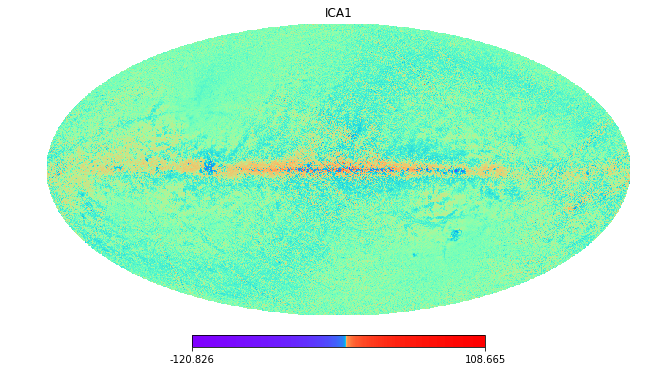

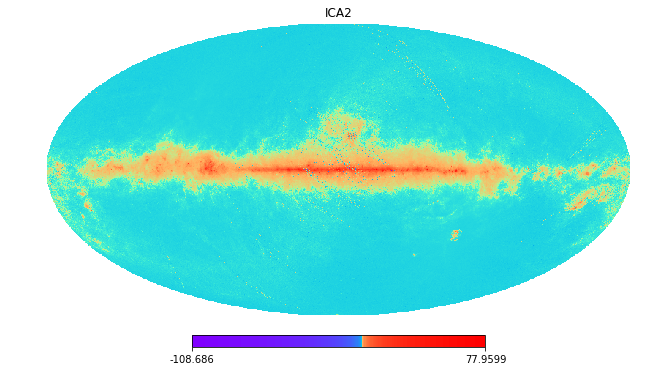

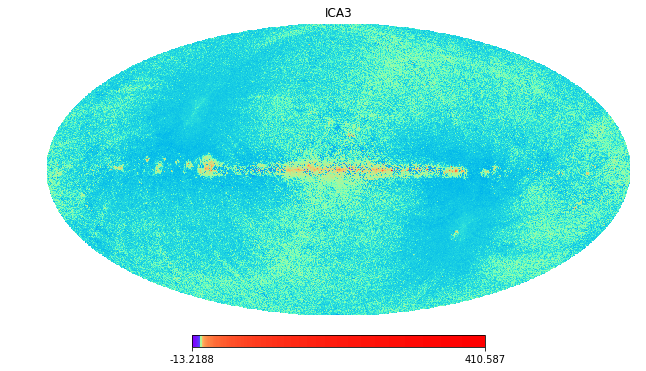

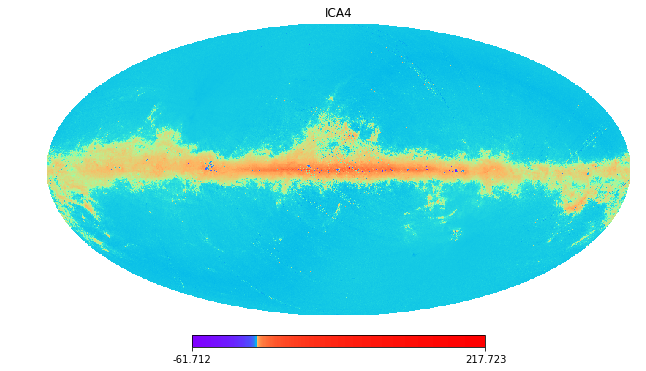

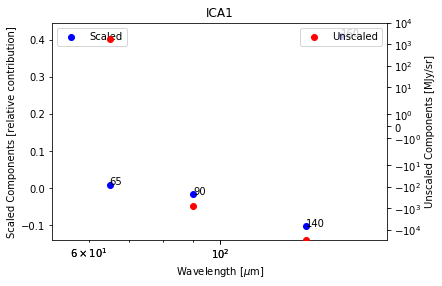

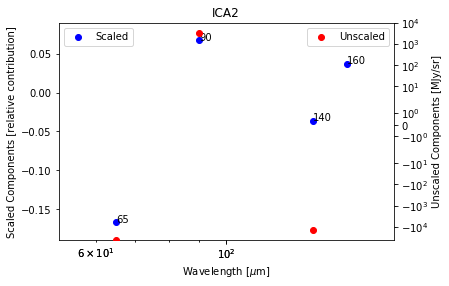

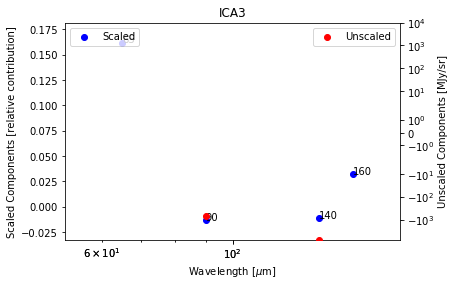

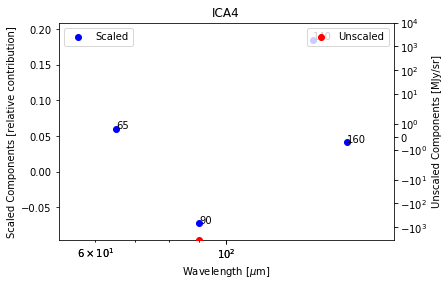

In [ ]:
doSeparation(fisframe, n_components=4)

In [ ]:
doSeparation(fisframe, method='NMF', n_components=4)

In [ ]:
doSeparation(fisframe, method='PCA', n_components=4)